In [1]:
!pip install huggingface_hub
!pip install datasets

from huggingface_hub import HfApi
from datasets import Dataset
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler
from huggingface_hub import notebook_login

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
import random
import os
import time
import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 10.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
# downloading the prepared dataset

ds = load_dataset("marvmk/scalable_project")
dd = pd.DataFrame(ds)
df = pd.DataFrame(ds['train'][:])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4992 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/marvmk___parquet/marvmk--scalable_project-58bc27d31b78bdd9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df = df.drop(columns=['Date'])
df

,Open,High,Low,Close,Volume,Inflation,CPI,Quarter_end
0,1346.930054,1384.910034,1336.979980,1384.849976,1287540000,0.957304,181.700,0
1,1382.359985,1389.439941,1374.609985,1387.079956,1149590000,0.962279,181.700,0
2,1390.189941,1428.650024,1390.089966,1421.319946,1567690000,0.953471,181.700,0
3,1424.260010,1442.260010,1416.229980,1431.569946,1755760000,0.959233,181.700,0
4,1423.290039,1424.119995,1399.060059,1401.069946,1457010000,0.963670,181.700,0
...,...,...,...,...,...,...,...,...
4987,10867.070312,10983.519531,10713.330078,10952.610352,4808710000,1.015125,298.012,0
4988,10996.969727,11210.379883,10996.969727,11199.120117,5141760000,1.014096,298.012,0
4989,10969.019531,11205.839844,10948.379883,10970.990234,5224440000,0.997705,298.012,0
4990,10971.950195,10998.730469,10780.500000,10792.669922,4773520000,0.996314,298.012,0


In [5]:
# splitting the dataset on train, validation and test and 
# training scaler on training set

test_size = int(len(df)/10)
train_set = df[:-test_size]
test_set = df[-test_size:]

validation_size = int(len(train_set)/10)
validation_set = train_set[-validation_size:]
train_set = train_set[:-validation_size]

# scaling
scaler = MinMaxScaler()
scaler.fit_transform(train_set.to_numpy())

train_set = scaler.transform(train_set.to_numpy())
validation_set = scaler.transform(validation_set.to_numpy())
test_set = scaler.transform(test_set.to_numpy())

# saving scaler to use later on inference
# scaler_filename = "scaler.save"
# joblib.dump(scaler, scaler_filename)
# from huggingface_hub import HfApi
# api = HfApi()
# api.upload_file(
#     path_or_fileobj="scaler.save",
#     path_in_repo="scaler.save",
#     repo_id="marvmk/scalable_project",
#     repo_type="dataset",
# )


In [6]:
#gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan  6 20:54:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 69

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.2


In [8]:
model_name ="Model-1"

In [9]:
def build_sequences(nump, target_labels=['Close'], window=10, stride=2, telescope=1):
    # Sanity check to avoid runtime errors
    df = pd.DataFrame(nump, columns = ['Open','High','Low','Close','Volume','Inflation', 'CPI', 'Quarter_end'])
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
X_train, y_train = build_sequences(train_set)
X_validation, y_validation = build_sequences(validation_set)
X_test, y_test = build_sequences(test_set)

In [11]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm1= tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True,return_state = False, kernel_initializer=tfk.initializers.GlorotUniform(seed)))(input_layer)
    lstm2 = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True ,return_state = False, kernel_initializer=tfk.initializers.GlorotUniform(seed)))(lstm1)
    lstm2 = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=False ,return_state = False, kernel_initializer=tfk.initializers.GlorotUniform(seed)))(lstm2)
    
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed))(lstm2)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.RootMeanSquaredError(),tfk.metrics.MeanAbsoluteError(),tfk.metrics.MeanAbsolutePercentageError()])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10, 8)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          28416     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                             

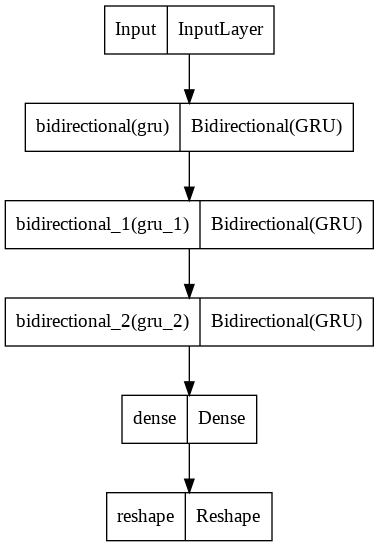

In [12]:
model = build_model(input_shape, output_shape)
model.summary()
print(model_name)

tfk.utils.plot_model(model, expand_nested=True)

In [13]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 1000,
    validation_data=[X_validation, y_validation],
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=20, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/1000
253/253 [==============================] - 25s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0208 - mean_absolute_percentage_error: 13.9889 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.0319 - val_mean_absolute_percentage_error: 2.8206 - lr: 0.0010
Epoch 2/1000
253/253 [==============================] - 3s 12ms/step - loss: 2.5435e-04 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 8.7956 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.0313 - val_mean_absolute_percentage_error: 2.7245 - lr: 0.0010
Epoch 3/1000
253/253 [==============================] - 3s 12ms/step - loss: 4.0686e-04 - root_mean_squared_error: 0.0202 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 8.6883 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.0301 - val_mean_absolute_percentage_err

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
model.save('/Scalable/FinalProject/model_stock_prices')

In [16]:
# # hopsworks version of model saving

# !pip install hopsworks
# import hopsworks

# project = hopsworks.login(api_key_value="YOUR_API_KEY")
# mr = project.get_model_registry()

# model_dir="stock_price_model"
# if os.path.isdir(model_dir) == False:
#     os.mkdir(model_dir)


# joblib.dump(model, model_dir + "/stock_price_model.pkl")

# # Create an entry in the model registry that includes the model's name, desc, metrics
# stock_price_model = mr.python.create_model(
#     name="stock_price_modal", 
#     description="Stock Price Predictor"
# )

# # Upload the model to the model registry, including all files in 'model_dir'
# stock_price_model.save(model_dir)


In [17]:
# huggingface version of saving

# api = HfApi()
# api.upload_folder(
#     folder_path="Model-1",
#     path_in_repo="Model-1",
#     repo_id="marvmk/model-test",
#     repo_type="model",
#     #ignore_patterns="**/logs/*.txt",
# )
# from huggingface_hub import hf_hub_url, cached_download
# import joblib

# REPO_ID = "marvmk/model-test"
# FILENAME = "models"

# from huggingface_hub import snapshot_download
# from huggingface_hub import hf_hub_download
# hf_hub_download(repo_id="marvmk/model-test", filename="Model-1", revision="main")

In [18]:
# drive version of model saving
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Scalable/FinalProject
model.save(model_name)

Mounted at /gdrive
/gdrive/MyDrive/Scalable/FinalProject


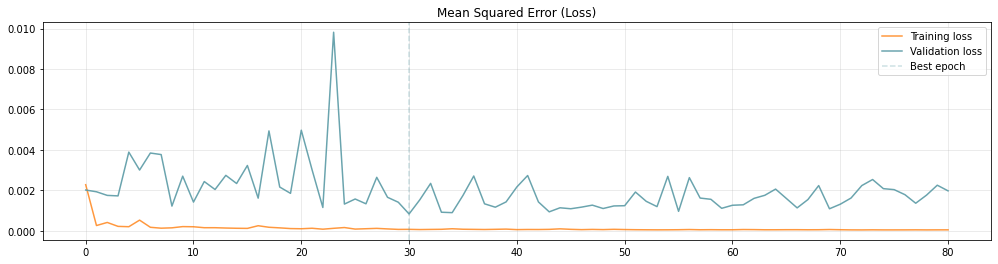

In [19]:
# statistics on the model prediction

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot((history['loss']), label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot((history['val_loss']), label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [20]:
predictions = model.predict(X_test)
print(predictions.shape)

8/8 [==============================] - 3s 7ms/step
(245, 1, 1)


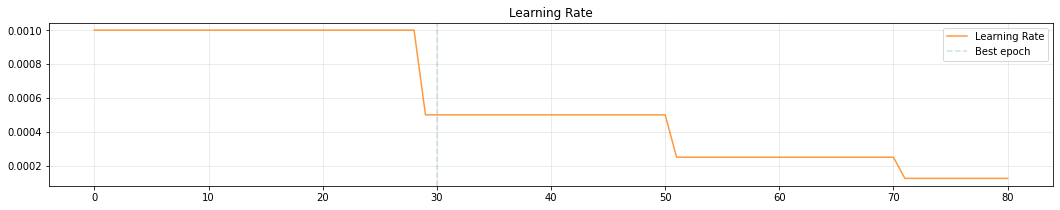

In [21]:
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Learning Rate')
plt.legend()
plt.grid(alpha=.3)
plt.show()


In [22]:
m = tfk.metrics.RootMeanSquaredError()
m.update_state(y_test.flatten(),predictions.flatten())
print("RMSE Test", m.result().numpy())

RMSE Test 0.14277567


In [23]:
m = tfk.metrics.MeanAbsoluteError()
m.update_state(y_test.flatten(),predictions.flatten())
print("MAE Test", m.result().numpy())

MAE Test 0.12947477


In [24]:
m = tfk.metrics.MeanAbsolutePercentageError()
m.update_state(y_test.flatten(),predictions.flatten())
print("MAPE Test", m.result().numpy())

MAPE Test 7.0041776


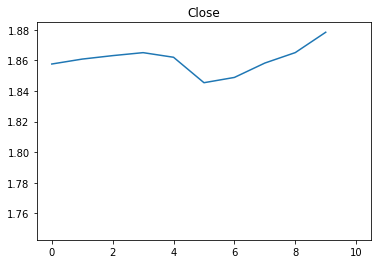

In [25]:
def inspect_prediction(X, y, pred, telescope=1, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, ax = plt.subplots()
    ax.plot(np.arange(len(X[0,:,1])), X[idx,:,1])
    ax.plot(np.arange(len(X[0,:,1]), len(X_train[0,:,1])+telescope), y[idx,:,], color='orange')
    ax.plot(np.arange(len(X[0,:,1]), len(X_train[0,:,1])+telescope), pred[idx,:], color='green')
    ax.set_title("Close")
    plt.show()

inspect_prediction(X_test, y_test, predictions)

In [26]:
# testing the loaded model

new_model = tf.keras.models.load_model('Model-1')

In [27]:
predictions = model.predict(X_test)
m = tfk.metrics.MeanAbsolutePercentageError()
m.update_state(y_test.flatten(),predictions.flatten())
print("MAPE Test", m.result().numpy())

8/8 [==============================] - 0s 6ms/step
MAPE Test 7.0041776
